### Imports

In [10]:
from random import choice
from random import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.core.display import Image


### Booleanization of multi-valued properties 
![Boolianzied](booleanizedTable.png)

#### Advantages of Boolean features
- **Boolean algebra** is the same as propositional logic, which models logical reasoning with True and False statements.
- You can use **Boolean algebra** – the language of computers – to build patterns.
- Boolean features fit well with a computer because you can store them individually as bits.


In [11]:
# Recurrent and non-recurrent patients
patients1 = [
    {'Menopause ge40': True, 'Inv-nodes 3-5': True, 'Deg-malign 3': True},
    {'Menopause lt40': True, 'Inv-nodes 0-2': True, 'Deg-malign 3': True},
    {'Menopause ge40': True, 'Inv-nodes 6-8': True, 'Deg-malign 3': True},
    {'Menopause ge40': True, 'Inv-nodes 0-2': True, 'Deg-malign 2': True},
    {'Menopause premeno': True, 'Inv-nodes 0-2': True, 'Deg-malign 3': True},
    {'Menopause premeno':True , 'Inv-nodes 0-2': True, 'Deg-malign 1': True}
]

patients = [
    {'Menopause lt40': False, 'Menopause ge40': True, 'Menopause premeno': False, 'Inv-nodes 0-2': False, 'Inv-nodes 3-5': True, 'Inv-nodes 6-8': False, 
     'Deg-malign 1': False, 'Deg-malign 2': False, 'Deg-malign 3': True},
    
    {'Menopause lt40': True, 'Menopause ge40': False, 'Menopause premeno': False, 'Inv-nodes 0-2': True, 'Inv-nodes 3-5': False, 'Inv-nodes 6-8': False, 
     'Deg-malign 1': False, 'Deg-malign 2': False, 'Deg-malign 3': True},
    
    {'Menopause lt40': False, 'Menopause ge40': True, 'Menopause premeno': False, 'Inv-nodes 0-2': False, 'Inv-nodes 3-5': False, 'Inv-nodes 6-8': True, 
     'Deg-malign 1': False, 'Deg-malign 2': False, 'Deg-malign 3': True},
    
    {'Menopause lt40': False, 'Menopause ge40': True, 'Menopause premeno': False, 'Inv-nodes 0-2': True, 'Inv-nodes 3-5': False, 'Inv-nodes 6-8': False, 
     'Deg-malign 1': False, 'Deg-malign 2': True, 'Deg-malign 3': False},
    
    {'Menopause lt40': False, 'Menopause ge40': False, 'Menopause premeno': True, 'Inv-nodes 0-2': True, 'Inv-nodes 3-5': False, 'Inv-nodes 6-8': False, 
     'Deg-malign 1': False, 'Deg-malign 2': False, 'Deg-malign 3': True},
    
    {'Menopause lt40': False, 'Menopause ge40': False, 'Menopause premeno': True, 'Inv-nodes 0-2': True, 'Inv-nodes 3-5': False, 'Inv-nodes 6-8': False, 
     'Deg-malign 1': True, 'Deg-malign 2': False, 'Deg-malign 3': False},
]



# Rule for recurrent patient - Not used for i and ii
Rules = [{'Deg-malign 3', 'NOT Menopause lt40'},
         {'Deg-malign 3'},
         {'NOT Inv-nodes 0-2'}]



### Memory system
![rule_memory_example](rule_memory_example.png)

#### Key points of a memory system
- A way for the tsetlin machine to remember important features



In [12]:
class Memory:
    def __init__(self, forget_value, memorize_value, memory):
        self.memory = memory
        self.forget_value = forget_value
        self.memorize_value = memorize_value
        self.memoryAmount = 20
        self.memoryLine = (self.memoryAmount / 2) + 1

    def get_memory(self):
        return self.memory

    def get_literals(self):
        return list(self.memory.keys())

    def get_condition(self):
        condition = []
        for literal in self.memory:
            if self.memory[literal] >= self.memoryLine:
                condition.append(literal)
        return condition

    def memorize(self, literal):
        if random() <= self.memorize_value and self.memory[literal] < self.memoryAmount:
            self.memory[literal] += 1

    def forget(self, literal):
        if random() <= self.forget_value and self.memory[literal] > 1:
            self.memory[literal] -= 1

    def memorize_always(self, literal):
        if  self.memory[literal] < self.memoryAmount:
            self.memory[literal] += 1

### Type i and ii feedback

#### Type i feedback
The type_i_feedback() method produces frequent patterns with two learning steps:
- Check if the condition part of the rule is True by assessing the object's literals. If the condition part is True, then memorize all the literals that are True for the object.
- Forget all remaining literals.

#### Type ii feedback
The type_ii_feedback() method implements the third and final learning step:

- Check if the condition part of the rule is True by assessing the object’s literals. If the condition part is True, then memorize all Forgotten literals that are False for the object. This time there is no randomization – the increment is always performed.

In [13]:
def evaluate_condition(observation, condition):
    truth_value_of_condition = True
    for feature in observation:
        if feature in condition and observation[feature] == False:
            truth_value_of_condition = False
            break
        if 'NOT ' + feature in condition and observation[feature] == True:
            truth_value_of_condition = False
            break
    return truth_value_of_condition


def type_i_feedback(observation, memory):
    remaining_literals = memory.get_literals()
    #print(remaining_literals)
    if evaluate_condition(observation, memory.get_condition()):
        for feature in observation:
            #print('Feature: ' + feature)
            if observation[feature]:
                memory.memorize(feature)
                remaining_literals.remove(feature)
            elif not observation[feature]:
                memory.memorize('NOT ' + feature)
                remaining_literals.remove('NOT ' + feature)
    for literal in remaining_literals:
        #print('Remaining Literal:' + literal)
        memory.forget(literal)
        
def type_ii_feedback(observation, memory):
    if evaluate_condition(observation, memory.get_condition()):
        for feature in observation:
            if not observation[feature]:
                memory.memorize_always(feature)
            elif observation[feature]:
                memory.memorize_always('NOT ' + feature)

### Generating features

This function creates the different features the patients can have including 'NOT' features. This will then be used for the creating of Recurrence and NonRecurrence Rules

In [14]:
def GenerateRules():
    StartingMemory = 10
    RecurrenceConditions = {}
    
    # Design-malign rules
    for i in range(3):
        RecurrenceConditions[f'Deg-malign {str(i+1)}'] = StartingMemory
    for i in range(3):
        RecurrenceConditions[f'NOT Deg-malign {str(i+1)}'] = StartingMemory

    # Menopause
    Menopause = ['ge40', 'lt40', 'premeno']
    for menop in Menopause:
        RecurrenceConditions[f'Menopause {menop}'] = StartingMemory
    for menop in Menopause:
        RecurrenceConditions[f'NOT Menopause {menop}'] = StartingMemory

    # Inv-nodes
    InvNodes = ['0-2', '3-5', '6-8']
    for invnode in InvNodes:
        RecurrenceConditions[f'Inv-nodes {invnode}'] = StartingMemory
    for invnode in InvNodes:
        RecurrenceConditions[f'NOT Inv-nodes {invnode}'] = StartingMemory
    
    return RecurrenceConditions

GenerateRules()

{'Deg-malign 1': 10,
 'Deg-malign 2': 10,
 'Deg-malign 3': 10,
 'NOT Deg-malign 1': 10,
 'NOT Deg-malign 2': 10,
 'NOT Deg-malign 3': 10,
 'Menopause ge40': 10,
 'Menopause lt40': 10,
 'Menopause premeno': 10,
 'NOT Menopause ge40': 10,
 'NOT Menopause lt40': 10,
 'NOT Menopause premeno': 10,
 'Inv-nodes 0-2': 10,
 'Inv-nodes 3-5': 10,
 'Inv-nodes 6-8': 10,
 'NOT Inv-nodes 0-2': 10,
 'NOT Inv-nodes 3-5': 10,
 'NOT Inv-nodes 6-8': 10}

### Classifying the patients and separating them to recurrent and non-recurrent groups

In [15]:
ReccurentPatients = []
NonReccurentPatients = []

def ManuallyClassify(observation, rules):
    votes = 0
    for feature in observation:
        for rule in rules:
            if feature in rule and observation[feature] == True:
                votes += 1
            if 'NOT ' + feature in rule and observation[feature] == True:
                votes -= 1
    if votes > 0:
        ReccurentPatients.append(observation)
        return "Recurrence"
    if votes <= 0:
        NonReccurentPatients.append(observation)
        return "Non-Recurrence"

for patient in patients:
    print(ManuallyClassify(patient, Rules))

print('##############################   RECURRENT PATIENTS    ############################################')    
print(ReccurentPatients)
print('#############################   NON-RECURRENT PATIENTS   ##########################################')    
print(NonReccurentPatients)

Recurrence
Non-Recurrence
Recurrence
Non-Recurrence
Recurrence
Non-Recurrence
##############################   RECURRENT PATIENTS    ############################################
[{'Menopause lt40': False, 'Menopause ge40': True, 'Menopause premeno': False, 'Inv-nodes 0-2': False, 'Inv-nodes 3-5': True, 'Inv-nodes 6-8': False, 'Deg-malign 1': False, 'Deg-malign 2': False, 'Deg-malign 3': True}, {'Menopause lt40': False, 'Menopause ge40': True, 'Menopause premeno': False, 'Inv-nodes 0-2': False, 'Inv-nodes 3-5': False, 'Inv-nodes 6-8': True, 'Deg-malign 1': False, 'Deg-malign 2': False, 'Deg-malign 3': True}, {'Menopause lt40': False, 'Menopause ge40': False, 'Menopause premeno': True, 'Inv-nodes 0-2': True, 'Inv-nodes 3-5': False, 'Inv-nodes 6-8': False, 'Deg-malign 1': False, 'Deg-malign 2': False, 'Deg-malign 3': True}]
#############################   NON-RECURRENT PATIENTS   ##########################################
[{'Menopause lt40': True, 'Menopause ge40': False, 'Menopause preme

### Learning recurrence rule (forget: 0.8, memorize: 0.2)

In [16]:
RecurrenceRule = Memory(0.8,0.2,GenerateRules())
for i in range(10000):
    observation_id = choice(range(3))
    patient = choice([0,1])
    if patient == 1:
        type_i_feedback(ReccurentPatients[observation_id], RecurrenceRule)
    else:
        type_ii_feedback(NonReccurentPatients[observation_id], RecurrenceRule)

print('#############################   GET MEMORY   ##########################################')     
print(RecurrenceRule.get_memory())
print('############################  GET CONDITION  ##########################################')
print(RecurrenceRule.get_condition())

#############################   GET MEMORY   ##########################################
{'Deg-malign 1': 1, 'Deg-malign 2': 1, 'Deg-malign 3': 20, 'NOT Deg-malign 1': 20, 'NOT Deg-malign 2': 20, 'NOT Deg-malign 3': 1, 'Menopause ge40': 1, 'Menopause lt40': 1, 'Menopause premeno': 1, 'NOT Menopause ge40': 1, 'NOT Menopause lt40': 20, 'NOT Menopause premeno': 1, 'Inv-nodes 0-2': 1, 'Inv-nodes 3-5': 1, 'Inv-nodes 6-8': 3, 'NOT Inv-nodes 0-2': 2, 'NOT Inv-nodes 3-5': 1, 'NOT Inv-nodes 6-8': 1}
############################  GET CONDITION  ##########################################
['Deg-malign 3', 'NOT Deg-malign 1', 'NOT Deg-malign 2', 'NOT Menopause lt40']


#############################   GET MEMORY   ##########################################
{'Deg-malign 1': 1, 'Deg-malign 2': 1, 'Deg-malign 3': 20, 'NOT Deg-malign 1': 20, 'NOT Deg-malign 2': 20, 'NOT Deg-malign 3': 1, 'Menopause ge40': 5, 'Menopause lt40': 1, 'Menopause premeno': 1, 'NOT Menopause ge40': 2, 'NOT Menopause lt40': 20, 'NOT Menopause premeno': 4, 'Inv-nodes 0-2': 1, 'Inv-nodes 3-5': 1, 'Inv-nodes 6-8': 1, 'NOT Inv-nodes 0-2': 5, 'NOT Inv-nodes 3-5': 2, 'NOT Inv-nodes 6-8': 1}
############################  GET CONDITION  ##########################################
['Deg-malign 3', 'NOT Deg-malign 1', 'NOT Deg-malign 2', 'NOT Menopause lt40']


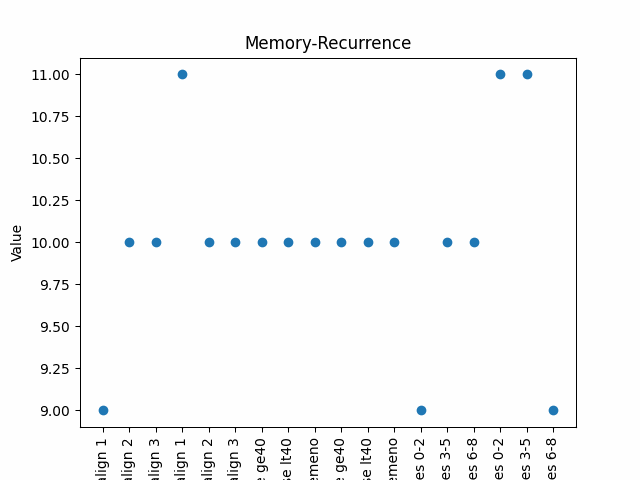

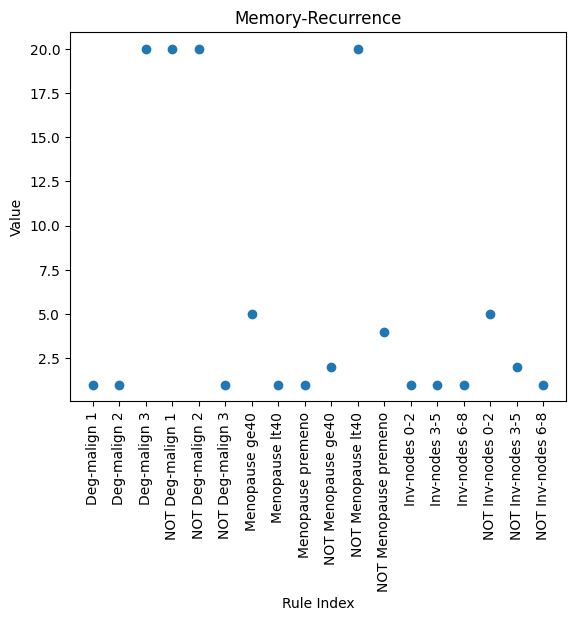

In [19]:
RecurrenceRule = Memory(0.8,0.2,GenerateRules())

def animate(i):
    observation_id = choice(range(3))
    patient = choice([0,1])
    if patient == 1:
        type_i_feedback(ReccurentPatients[observation_id], RecurrenceRule)
    else:
        type_ii_feedback(NonReccurentPatients[observation_id], RecurrenceRule)
        
    ax1.clear()
    memory = RecurrenceRule.get_memory()
    x_vals = range(len(memory))
    y_vals = list(memory.values())
    
    ax1.plot(x_vals, y_vals, 'o')
    
    ax1.set_title('Memory-Recurrence')
    ax1.set_xlabel('Rule Index')
    ax1.set_ylabel('Value')
    ax1.set_xticks(x_vals)
    ax1.set_xticklabels(memory.keys(), rotation=90) 
    
    
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
ani = animation.FuncAnimation(fig, animate, interval=1000, save_count=1000)
ani.save('animation_recurrenceRule.gif', writer='pillow', fps=60)

print('#############################   GET MEMORY   ##########################################')
print(RecurrenceRule.get_memory())
print('############################  GET CONDITION  ##########################################')
print(RecurrenceRule.get_condition())

# Display the GIF inline in Jupyter
display(Image(filename="animation_recurrenceRule.gif"))
plt.show()



### Learning non-recurrence rule (forget: 0.8, memorize: 0.2)

In [20]:
NonRecurrenceRule = Memory(0.8, 0.2, GenerateRules())
for i in range(10000):
    observation_id = choice(range(3))
    patient = choice([0, 1])
    if patient == 1:
        type_i_feedback(NonReccurentPatients[observation_id], NonRecurrenceRule)
    else:
        type_ii_feedback(ReccurentPatients[observation_id], NonRecurrenceRule)    

print('#############################   GET MEMORY   ##########################################')
print(NonRecurrenceRule.get_memory())
print('############################  GET CONDITION  ##########################################')
print(NonRecurrenceRule.get_condition())

#############################   GET MEMORY   ##########################################
{'Deg-malign 1': 1, 'Deg-malign 2': 7, 'Deg-malign 3': 1, 'NOT Deg-malign 1': 2, 'NOT Deg-malign 2': 1, 'NOT Deg-malign 3': 11, 'Menopause ge40': 1, 'Menopause lt40': 1, 'Menopause premeno': 1, 'NOT Menopause ge40': 2, 'NOT Menopause lt40': 2, 'NOT Menopause premeno': 5, 'Inv-nodes 0-2': 16, 'Inv-nodes 3-5': 1, 'Inv-nodes 6-8': 1, 'NOT Inv-nodes 0-2': 1, 'NOT Inv-nodes 3-5': 7, 'NOT Inv-nodes 6-8': 6}
############################  GET CONDITION  ##########################################
['NOT Deg-malign 3', 'Inv-nodes 0-2']


#############################   GET MEMORY   ##########################################
{'Deg-malign 1': 2, 'Deg-malign 2': 3, 'Deg-malign 3': 1, 'NOT Deg-malign 1': 1, 'NOT Deg-malign 2': 1, 'NOT Deg-malign 3': 15, 'Menopause ge40': 1, 'Menopause lt40': 1, 'Menopause premeno': 1, 'NOT Menopause ge40': 2, 'NOT Menopause lt40': 6, 'NOT Menopause premeno': 1, 'Inv-nodes 0-2': 15, 'Inv-nodes 3-5': 1, 'Inv-nodes 6-8': 1, 'NOT Inv-nodes 0-2': 1, 'NOT Inv-nodes 3-5': 5, 'NOT Inv-nodes 6-8': 9}
############################  GET CONDITION  ##########################################
['NOT Deg-malign 3', 'Inv-nodes 0-2']


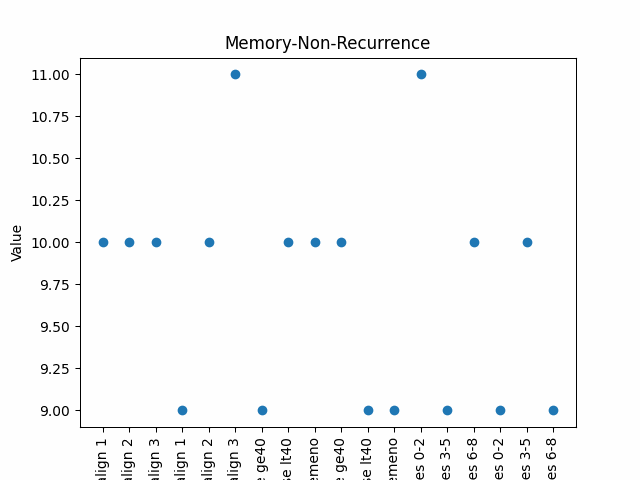

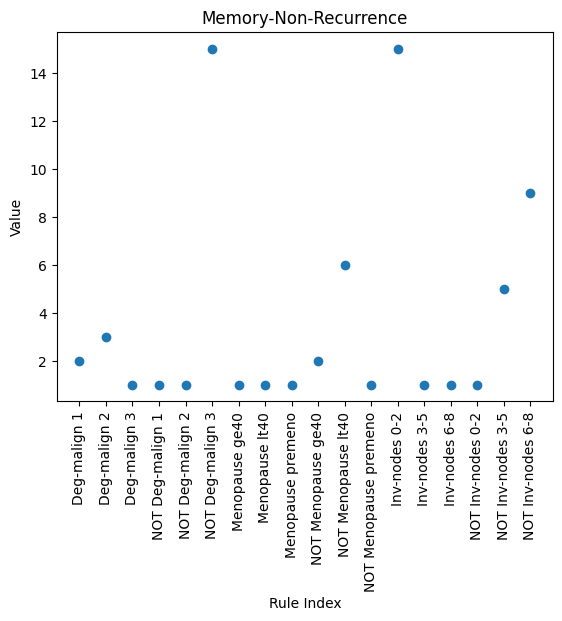

In [21]:
NonRecurrenceRule = Memory(0.8, 0.2, GenerateRules())

def animate(i):
    observation_id = choice(range(3))
    patient = choice([0, 1])
    if patient == 1:
        type_i_feedback(NonReccurentPatients[observation_id], NonRecurrenceRule)
    else:
        type_ii_feedback(ReccurentPatients[observation_id], NonRecurrenceRule)    
        
    ax1.clear()
    memory = NonRecurrenceRule.get_memory()
    x_vals = range(len(memory))
    y_vals = list(memory.values())
    
    ax1.plot(x_vals, y_vals, 'o')
    
    ax1.set_title('Memory-Non-Recurrence')
    ax1.set_xlabel('Rule Index')
    ax1.set_ylabel('Value')
    ax1.set_xticks(x_vals)
    ax1.set_xticklabels(memory.keys(), rotation=90) 
    
    
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
ani = animation.FuncAnimation(fig, animate, interval=1000, save_count=1000)
ani.save('animation_non_recurrenceRule.gif', writer='pillow', fps=60)

print('#############################   GET MEMORY   ##########################################')
print(NonRecurrenceRule.get_memory())
print('############################  GET CONDITION  ##########################################')
print(NonRecurrenceRule.get_condition())

# Display the GIF inline in Jupyter
display(Image(filename="animation_non_recurrenceRule.gif"))
plt.show()



### Classify patients using the new conditions set by i and ii

In [22]:
def classify(observation, positive_rules, negative_rules):
    votes = 0
    for feature in observation:
        for rule in positive_rules:
            if feature == rule and observation[feature] == True:
                votes += 1
            if 'NOT ' + feature == rule and observation[feature] == False:
                votes += 1
        for rule in negative_rules:
            if feature == rule and observation[feature] == True:
                votes -= 1
            if 'NOT ' + feature == rule and observation[feature] == False:
                votes -= 1   
    if votes > 0:
        return "Recurrence"
    if votes <= 0:
        return "Non-Recurrence"
    
print("########### RecurrenceRule RULES ################")
print(RecurrenceRule.get_condition())
print("########### NonRecurrenceRule RULES ################")
print(NonRecurrenceRule.get_condition())
print("\n")
    
for patient in patients:
    print(classify(patient, RecurrenceRule.get_condition(), NonRecurrenceRule.get_condition()))

########### RecurrenceRule RULES ################
['Deg-malign 3', 'NOT Deg-malign 1', 'NOT Deg-malign 2', 'NOT Menopause lt40']
########### NonRecurrenceRule RULES ################
['NOT Deg-malign 3', 'Inv-nodes 0-2']


Recurrence
Recurrence
Recurrence
Non-Recurrence
Recurrence
Non-Recurrence


### Task 7
Repeat 5. and 6. with forget value 0.5 and memorize value 0.5

In [45]:
RecurrenceRule = Memory(0.5,0.5,GenerateRules())
for i in range(10000):
    observation_id = choice(range(3))
    patient = choice([0,1])
    if patient == 1:
        type_i_feedback(ReccurentPatients[observation_id], RecurrenceRule)
    else:
        type_ii_feedback(NonReccurentPatients[observation_id], RecurrenceRule)

print('############################# RECURRENT GET MEMORY  ##########################################')     
print(RecurrenceRule.get_memory())
print('############################ RECURRENT GET CONDITION  ##########################################')
print(RecurrenceRule.get_condition())
print()

NonRecurrenceRule = Memory(0.5, 0.5, GenerateRules())
for i in range(10000):
    observation_id = choice(range(3))
    patient = choice([0, 1])
    if patient == 1:
        type_i_feedback(NonReccurentPatients[observation_id], NonRecurrenceRule)
    else:
        type_ii_feedback(ReccurentPatients[observation_id], NonRecurrenceRule)

print('#############################  NON-RECURRENT GET MEMORY   ##########################################')
print(NonRecurrenceRule.get_memory())
print('############################ NON-RECURRENT GET CONDITION  ##########################################')
print(NonRecurrenceRule.get_condition())
print()

attemptedClassification = []
print('################ Classification run ##################')
for patient in patients:
    attemptedClassification.append(classify(patient, RecurrenceRule.get_condition(), NonRecurrenceRule.get_condition()))
print(attemptedClassification)

############################# RECURRENT GET MEMORY  ##########################################
{'Deg-malign 1': 1, 'Deg-malign 2': 1, 'Deg-malign 3': 20, 'NOT Deg-malign 1': 19, 'NOT Deg-malign 2': 19, 'NOT Deg-malign 3': 1, 'Menopause ge40': 18, 'Menopause lt40': 1, 'Menopause premeno': 1, 'NOT Menopause ge40': 1, 'NOT Menopause lt40': 20, 'NOT Menopause premeno': 19, 'Inv-nodes 0-2': 1, 'Inv-nodes 3-5': 2, 'Inv-nodes 6-8': 2, 'NOT Inv-nodes 0-2': 19, 'NOT Inv-nodes 3-5': 4, 'NOT Inv-nodes 6-8': 1}
############################ RECURRENT GET CONDITION  ##########################################
['Deg-malign 3', 'NOT Deg-malign 1', 'NOT Deg-malign 2', 'Menopause ge40', 'NOT Menopause lt40', 'NOT Menopause premeno', 'NOT Inv-nodes 0-2']

#############################  NON-RECURRENT GET MEMORY   ##########################################
{'Deg-malign 1': 1, 'Deg-malign 2': 1, 'Deg-malign 3': 3, 'NOT Deg-malign 1': 17, 'NOT Deg-malign 2': 3, 'NOT Deg-malign 3': 1, 'Menopause ge40': 6, 'Men

### Task 8
Repeat 5. and 6. with forget value 0.2 and memorize value 0.8

In [24]:
RecurrenceRule = Memory(0.2,0.8,GenerateRules())
for i in range(10000):
    observation_id = choice(range(3))
    patient = choice([0, 1])
    if patient == 1:
        type_i_feedback(ReccurentPatients[observation_id], RecurrenceRule)
    else:
        type_ii_feedback(NonReccurentPatients[observation_id], RecurrenceRule)

print('############################# RECURRENT GET MEMORY  ##########################################')     
print(RecurrenceRule.get_memory())
print('############################ RECURRENT GET CONDITION  ##########################################')
print(RecurrenceRule.get_condition())
print()

NonRecurrenceRule = Memory(0.2, 0.8, GenerateRules())
for i in range(10000):
    observation_id = choice(range(3))
    patient = choice([0, 1])
    if patient == 1:
        type_i_feedback(NonReccurentPatients[observation_id], NonRecurrenceRule)
    else:
        type_ii_feedback(ReccurentPatients[observation_id], NonRecurrenceRule)

print('#############################  NON-RECURRENT GET MEMORY   ##########################################')
print(NonRecurrenceRule.get_memory())
print('############################ NON-RECURRENT GET CONDITION  ##########################################')
print(NonRecurrenceRule.get_condition())
print()

attemptedClassification = []
print('################ Classification run ##################')
for patient in patients:
    attemptedClassification.append(classify(patient, RecurrenceRule.get_condition(), NonRecurrenceRule.get_condition()))
print(attemptedClassification)



############################# RECURRENT GET MEMORY  ##########################################
{'Deg-malign 1': 1, 'Deg-malign 2': 1, 'Deg-malign 3': 20, 'NOT Deg-malign 1': 20, 'NOT Deg-malign 2': 20, 'NOT Deg-malign 3': 1, 'Menopause ge40': 20, 'Menopause lt40': 1, 'Menopause premeno': 1, 'NOT Menopause ge40': 1, 'NOT Menopause lt40': 20, 'NOT Menopause premeno': 20, 'Inv-nodes 0-2': 1, 'Inv-nodes 3-5': 1, 'Inv-nodes 6-8': 20, 'NOT Inv-nodes 0-2': 20, 'NOT Inv-nodes 3-5': 20, 'NOT Inv-nodes 6-8': 1}
############################ RECURRENT GET CONDITION  ##########################################
['Deg-malign 3', 'NOT Deg-malign 1', 'NOT Deg-malign 2', 'Menopause ge40', 'NOT Menopause lt40', 'NOT Menopause premeno', 'Inv-nodes 6-8', 'NOT Inv-nodes 0-2', 'NOT Inv-nodes 3-5']

#############################  NON-RECURRENT GET MEMORY   ##########################################
{'Deg-malign 1': 18, 'Deg-malign 2': 1, 'Deg-malign 3': 1, 'NOT Deg-malign 1': 1, 'NOT Deg-malign 2': 19, 'NOT De

### Tests 1

In [30]:
correctClassification = ["Recurrence", "Non-Recurrence", "Recurrence", "Non-Recurrence", "Recurrence", "Non-Recurrence"]

attemptedClassification = []
attemptedIterations = 0
ForgetProbability = 0.5

def classify(observation, positive_rules, negative_rules):
    votes = 0
    for feature in observation:
        for rule in positive_rules:
            if feature == rule and observation[feature] == True:
                votes += 1
            if 'NOT ' + feature == rule and observation[feature] == False:
                votes += 1
        for rule in negative_rules:
            if feature == rule and observation[feature] == True:
                votes -= 1
            if 'NOT ' + feature == rule and observation[feature] == False:
                votes -= 1   
    if votes > 0:
        return "Recurrence"
    if votes <= 0:
        return "Non-Recurrence"

while correctClassification != attemptedClassification:
    attemptedIterations += 1
    RecurrenceRule = Memory(ForgetProbability,(1-ForgetProbability),GenerateRules())
    NonRecurrenceRule = Memory(ForgetProbability,(1-ForgetProbability), GenerateRules())
    attemptedClassification.clear()

    for i in range(10000):
        observation_id = choice(range(3))
        patient = choice([0, 1])
        if patient == 1:
            type_i_feedback(ReccurentPatients[observation_id], RecurrenceRule)
        else:
            type_ii_feedback(NonReccurentPatients[observation_id], RecurrenceRule)

    for i in range(10000):
        observation_id = choice(range(3))
        patient = choice([0, 1])
        if patient == 1:
            type_i_feedback(NonReccurentPatients[observation_id], NonRecurrenceRule)
        else:
            type_ii_feedback(ReccurentPatients[observation_id], NonRecurrenceRule)
    
    print('################ Classification run ##################')
    for patient in patients:
        attemptedClassification.append(classify(patient, RecurrenceRule.get_condition(), NonRecurrenceRule.get_condition()))
    print(attemptedClassification)
    print('\n')

print('################ FINAL RUN ##################')
print(attemptedClassification)
print('Iterations required with 10000 iterations of rule learning: ', attemptedIterations)


################ Classification run ##################
['Recurrence', 'Recurrence', 'Recurrence', 'Non-Recurrence', 'Non-Recurrence', 'Non-Recurrence']


################ Classification run ##################
['Recurrence', 'Non-Recurrence', 'Recurrence', 'Non-Recurrence', 'Non-Recurrence', 'Non-Recurrence']


################ Classification run ##################
['Recurrence', 'Recurrence', 'Recurrence', 'Non-Recurrence', 'Non-Recurrence', 'Non-Recurrence']


################ Classification run ##################
['Recurrence', 'Non-Recurrence', 'Recurrence', 'Non-Recurrence', 'Non-Recurrence', 'Non-Recurrence']


################ Classification run ##################
['Recurrence', 'Non-Recurrence', 'Recurrence', 'Non-Recurrence', 'Recurrence', 'Non-Recurrence']


################ FINAL RUN ##################
['Recurrence', 'Non-Recurrence', 'Recurrence', 'Non-Recurrence', 'Recurrence', 'Non-Recurrence']
Iterations required with 10000 iterations of rule learning:  5
